In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
from pycmqlib3.utility import dbaccess, dataseries, misc
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2023, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# define product groups and start times

In [3]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

# load historical data

In [4]:
fields = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

start_date = datetime.date(2010,1,1)
end_date = datetime.date(2023,5,25)
shift_mode = 2
roll_name = 'hot'
roll_file_loc = "C:/dev/wtdev/config/"
sim_markets = all_markets
nb_cont = 2
freq='d1'

data_df = pd.DataFrame()

for prodcode in sim_markets:
    for nb in range(nb_cont):
        xdf = dataseries.nearby(prodcode,
                                nb+1,
                                start_date=start_date, 
                                end_date = end_date, 
                                shift_mode = shift_mode,
                                freq=freq, 
                                roll_name=roll_name, 
                                config_loc=roll_file_loc)
        xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
        xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
        xdf['product'] = prodcode
        xdf['code'] = f'c{nb+1}'
        data_df = data_df.append(xdf)

df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = list(fields), aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['product', 'code', 'field',], inplace = True)
df.index = pd.to_datetime(df.index)
df.tail(5)

product         AP                                                         \
code            c1                                                          
field        close contract  diff_oi      expiry    high     low      mth   
date                                                                        
2023-05-19  8552.0   AP2310  -5483.0  2023-10-20  8585.0  8480.0  24286.0   
2023-05-22  8657.0   AP2310  29927.0  2023-10-20  8660.0  8311.0  24286.0   
2023-05-23  8480.0   AP2310 -20592.0  2023-10-20  8635.0  8433.0  24286.0   
2023-05-24  8442.0   AP2310  -1251.0  2023-10-20  8514.0  8374.0  24286.0   
2023-05-25  8573.0   AP2310   2123.0  2023-10-20  8593.0  8413.0  24286.0   

product                                                                   \
code                                                 c2                    
field         open openInterest shift    volume   close contract diff_oi   
date                                                                       
2023-05-19  8562.0     138325.0   0.0   88807.0  8375.0   AP2311   156.0   
2023-05-22  8521.0     168252.0   0.0  237496.0  8458.0   AP2311    46.0   
2023-05-23  8630.0     147660.0   0.0  146877.0  8307.0   AP2311   -51.0   
2023-05-24  8450.0     146409.0   0.0   97626.0  8276.0   AP2311    -1.0   
2023-05-25  8440.0     148532.0   0.0  124732.0  8398.0   AP2311   -33.0   

product                                                                     \
code                                                                         
field           expiry    high     low      mth    open openInterest shift   
date                                                                         
2023-05-19  2023-11-14  8407.0  8313.0  24287.0  8407.0      10435.0   0.0   
2023-05-22  2023-11-14  8472.0  8158.0  24287.0  8367.0      10481.0   0.0   
2023-05-23  2023-11-14  8500.0  8265.0  24287.0  8437.0      10430.0   0.0   
2023-05-24  2023-11-14  8335.0  8206.0  24287.0  8286.0      10429.0   0.0   
2023-05-25  2023-11-14  8407.0  8252.0  24287.0  8281.0      10396.0   0.0   

product                 CF                                                  \
code                    c1                                                   
field      volume    close contract  diff_oi      expiry     high      low   
date                                                                         
2023-05-19  641.0  15995.0   CF2309  10464.0  2023-09-14  16040.0  15690.0   
2023-05-22  972.0  16125.0   CF2309   1944.0  2023-09-14  16340.0  15965.0   
2023-05-23  417.0  16135.0   CF2309   6494.0  2023-09-14  16280.0  16055.0   
2023-05-24  621.0  15725.0   CF2309 -28340.0  2023-09-14  16210.0  15720.0   
2023-05-25  416.0  15565.0   CF2309 -35199.0  2023-09-14  15770.0  15420.0   

product                                                                      \
code                                                            c2            
field           mth     open openInterest shift    volume    close contract   
date                                                                          
2023-05-19  24285.0  15805.0     647982.0   0.0  688357.0  16290.0   CF2401   
2023-05-22  24285.0  16005.0     649926.0   0.0  926366.0  16460.0   CF2401   
2023-05-23  24285.0  16095.0     656420.0   0.0  628702.0  16465.0   CF2401   
2023-05-24  24285.0  16155.0     628077.0   0.0  766213.0  16040.0   CF2401   
2023-05-25  24285.0  15700.0     592878.0   0.0  908282.0  15840.0   CF2401   

product                                                              \
code                                                                  
field       diff_oi      expiry     high      low      mth     open   
date                                                                  
2023-05-19   4915.0  2024-01-12  16335.0  15990.0  24289.0  16100.0   
2023-05-22  15714.0  2024-01-12  16645.0  16255.0  24289.0  16300.0   
2023-05-23   2500.0  2024-01-12  16600.0  16370.0  24289.0  16420.0   
2023-0

In [5]:
for prodcode in sim_markets:
    if shift_mode == 1:
        df[(prodcode, 'c1', 'ryield')]= np.log(df[(prodcode, 'c1', 'close')] - df[(prodcode, 'c1', 'shift')]) - \
                                            np.log(df[(prodcode, 'c2', 'close')] - df[(prodcode, 'c2', 'shift')])
        df[(prodcode, 'c1', 'pct_chg')] = (df[(prodcode, 'c1', 'close')] - df[(prodcode, 'c1', 'shift')])/(df[(prodcode, 'c1', 'close')].shift(1) - df[(prodcode, 'c1', 'shift')]) - 1
        df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
    elif shift_mode == 0:
        df[(prodcode, 'c1', 'ryield')] = np.log(df[(prodcode, 'c1', 'close')])-np.log(df[(prodcode, 'c2', 'close')])
        df[(prodcode, 'c1', 'pct_chg')] = df[(prodcode, 'c1', 'close')].pct_change()
        df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
    elif shift_mode == 2:
        df[(prodcode, 'c1', 'ryield')]= np.log(df[(prodcode, 'c1', 'close')])-np.log(df[(prodcode, 'c2', 'close')]) - \
                                            df[(prodcode, 'c1', 'shift')] + df[(prodcode, 'c2', 'shift')]
        df[(prodcode, 'c1', 'pct_chg')] = df[(prodcode, 'c1', 'close')].pct_change()
        df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
    df[(prodcode, 'c1', 'px_chg')] = df[(prodcode, 'c1', 'close')].diff()
    df[(prodcode, 'c1', 'ryield')] = df[(prodcode, 'c1', 'ryield')]/(df[(prodcode, 'c2', 'mth')] - df[(prodcode, 'c1', 'mth')])*12.0
adf = df.copy(deep=True)


C:\Users\harvey\AppData\Local\Temp/ipykernel_53356/332754688.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[(prodcode, 'c1', 'lr')] = np.log(1 + df[(prodcode, 'c1', 'pct_chg')])
C:\Users\harvey\AppData\Local\Temp/ipykernel_53356/332754688.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[(prodcode, 'c1', 'px_chg')] = df[(prodcode, 'c1', 'close')].diff()
C:\Users\harvey\AppData\Local\Temp/ipykernel_53356/332754688.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

# Calculate features

In [6]:
leadlag_portfolio = {
    'ferrous': {'lead': ['hc', 'rb', ],
                'lag': ['rb', 'hc', 'i', 'j', 'jm', 'SM', ],
                'param_rng': [40, 60, 2],
                },
    'constrs': {'lead': ['hc', 'rb', 'v'],
                'lag': ['FG', 'SA', 'v', 'UR', ],
                'param_rng': [40, 60, 2],
                },
    'petchem': {'lead': ['v'],
                'lag': ['TA', 'MA', 'pp', 'eg', 'eb', 'PF', ],
                'param_rng': [40, 60, 2],
                },
    'base': {'lead': ['al'],
             'lag': ['al', 'ni', 'sn', 'ss', ],  # 'zn', 'cu'
             'param_rng': [40, 60, 2],
             },
    'oil': {'lead': ['sc'],
            'lag': ['sc', 'pg', 'bu', ],
            'param_rng': [20, 30, 2],
            },
    'bean': {'lead': ['b'],
             'lag': ['p', 'y', 'OI', ],
             'param_rng': [60, 80, 2],
             },
}


def lead_lag(df, input_args, leadlag_port=leadlag_portfolio):
    product_list = input_args['product_list']
    signal_cap = input_args.get('signal_cap', None)
    conv_func = input_args.get('conv_func', 'qtl')
    signal_df = pd.DataFrame(index=df.index, columns=product_list)
    for asset in product_list:
        for sector in leadlag_port:
            if asset in leadlag_port[sector]['lag']:
                signal_list = []
                for lead_prod in leadlag_port[sector]['lead']:
                    feature_ts = df[(lead_prod, 'c1', 'close')]
                    signal_ts = calc_conv_signal(feature_ts.dropna(), conv_func,
                                                 leadlag_port[sector]['param_rng'], signal_cap=signal_cap)
                    signal_list.append(signal_ts)
                signal_df[asset] = pd.concat(signal_list, axis=1).mean(axis=1)
                break
            else:
                signal_df[asset] = 0
    return signal_df

In [30]:
leadlag_repo = {
    'ferrous': {'lead': ['hc', 'rb', 'v'],
                'lag': ['rb', 'hc', 'i', 'j', 'jm', 'SM', 'FG', 'SA', 'v', 'UR', 'SF'],
                'param_rng': [40, 80, 2],
                },
    'petchem': {'lead': ['v'],
                'lag': ['TA', 'MA', 'pp', 'eg', 'eb', 'PF',  'al', 'cu', 'zn',], # 
                'param_rng': [40, 80, 2],
                },
#     'base0': {'lead': ['v'],
#              'lag': ['al', 'cu', 'zn',],  # 'zn', 'cu'
#              'param_rng': [40, 60, 2],
#              },
    'base': {'lead': ['al'],
             'lag': ['ni', 'sn', 'ss', ],  # 'zn', 'cu'
             'param_rng': [40, 80, 2],
             },
    'oil': {'lead': ['sc'],
            'lag': ['sc', 'pg', 'bu', ],
            'param_rng': [20, 30, 2],
            },
    'bean': {'lead': ['b'],
             'lag': ['p', 'y', 'OI', ],
             'param_rng': [60, 80, 2],
             },
}

asset_list = [
    'rb', 'hc', 'i', 'j', 'jm', 'SM', 'FG', 'v', 'UR', 
    'sc', 'al', 'ni', 'sn', 'ss', 'TA', 'pp', 'eg', 'eb', 'p', 'y', 'OI', 'SF'
]
input_args = {
    'product_list': asset_list,
    'conv_func': 'qtl',
    'signal_cap': None,
}
signal_df = lead_lag(df, input_args, leadlag_repo)

# signal_df = pd.DataFrame(index=df.index, columns=asset_list)
# for asset in asset_list:
#     signal_df[asset] = calc_conv_signal(df[(asset, 'c1', 'close')].dropna(), 'qtl', [40, 80, 2], signal_cap=None)
# signal_df


portfolio sharpe:
%s
 sharpe       1.754144
sharpe_6m    1.837292
sharpe_1y    1.478732
sharpe_2y    1.618454
sharpe_3y    2.371509
sharpe_4y    2.227379
sharpe_5y    2.161465
sharpe_6y    2.027872
sharpe_7y    2.024427
sharpe_8y    2.098344
sharpe_9y    1.967450
Name: total, dtype: float64
asset sharpe:
%s
 product          rb        hc         i         j        jm        SM  \
sharpe     1.267907  1.263789  1.341965  1.559211  0.973019  0.788209   
sharpe_6m  1.996493  1.903048  1.719721  0.974710  1.139020 -0.277031   
sharpe_1y  1.273981  1.395603  0.957444  0.709959  0.750774  0.584080   
sharpe_2y  0.401851  0.596394  0.110924  0.773117  1.035535  0.780354   
sharpe_3y  1.193724  1.657526  1.222708  1.043483  1.279977  0.718770   
sharpe_4y  0.775278  1.273083  1.028585  0.839558  0.962769  0.769847   
sharpe_5y  1.048707  1.261777  1.199013  0.938550  0.799772  0.882176   
sharpe_6y  0.855222  1.106601  1.035191  1.057081  0.750905  0.882662   
sharpe_7y  0.874072  1.108779  1.

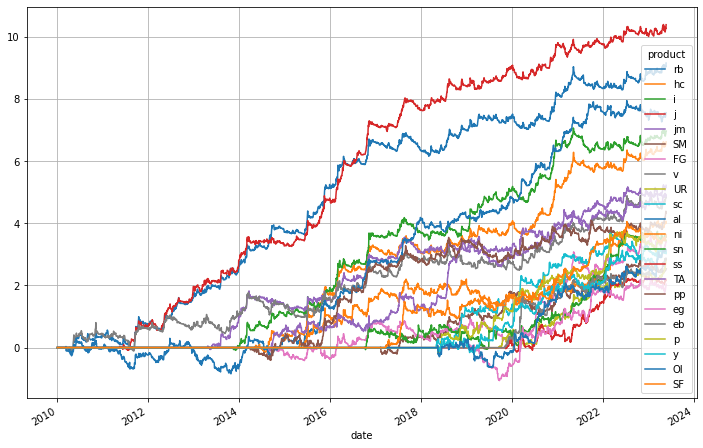

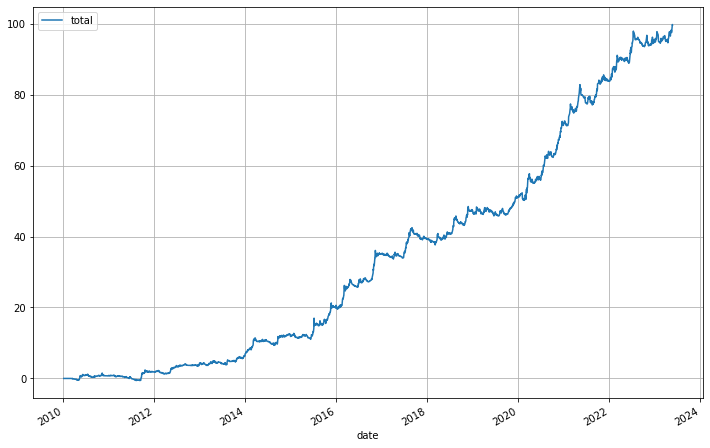

In [31]:
vol_win=20
vol_df = get_asset_vols(df, asset_list, vol_win=vol_win, vol_type='pct_chg')

holding = generate_holding_from_signal(signal_df, vol_df,
                                       risk_scaling=1.0,
                                       asset_scaling=False)
df_pxchg = get_px_chg(df, exec_mode='open', chg_type='pct', contract='c1')
df_pxchg = df_pxchg[asset_list].reindex(index=holding.index)

bt_metrics = MetricsBase(holdings=holding[asset_list],
                         returns=df_pxchg[asset_list])

pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y']
pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors, perf_metrics=['sharpe', 'std'])
print('portfolio sharpe:\n%s\n', pnl_stats['sharpe'])
print('asset sharpe:\n%s\n', pnl_stats['asset_sharpe_stats'])
print('turnover: %s\n pnl_per_trade: %s\n' % (pnl_stats['turnover'], pnl_stats['pnl_per_trade']))

pnl_stats['asset_cumpnl'].plot()
plt.grid()
plt.show()
pnl_stats['portfolio_cumpnl'].plot()
plt.grid()
plt.show()
